In [3]:
import math

# helper functions

# subgraph creation, bgpNetwork needs to be established and the provided asn value must be a STRING and present in the graph
def bgpSubgraph(asn):
    subgraphNodes = [asn] + list(bgpNetwork.neighbors(asn))
    subgraph = bgpNetwork.subgraph(subgraphNodes)
    return subgraph


def haversine(lat1, lon1, lat2, lon2):
    # convert coordinates into radian form for calculation
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # get differences
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return 6371 * c
    

In [4]:
import requests
import random
import time
import aiohttp
import asyncio
import nest_asyncio

#gets rank and cone
def get_caida_as_info(asn):
    url = f"https://api.asrank.caida.org/v2/restful/asns/{asn}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        rank = data['data']['asn']['rank']
        cone = data['data']['asn']['customerCone']['numberAsns']
        return rank, cone
    return None, None

# doing the following separately from the above just so the methods are more clear with return
# get latitude and longitude coordinates of an asn
async def get_location(session, asn):
    url = f"https://api.asrank.caida.org/v2/restful/asns/{asn}"
    try:
        async with session.get(url, timeout=aiohttp.ClientTimeout(total=10)) as response:
            if response.status == 200:
                data = await response.json()
                if not data['data']['asn']:
                    return asn, (None, None)
                latitude = data['data']['asn']['latitude']
                longitude = data['data']['asn']['longitude']
                return asn, (latitude, longitude)
    except asyncio.TimeoutError:
        print(f"Timeout while fetching ASN {asn}")
        return asn, "timeout"
    except Exception as e:
        print(f"Error fetching ASN {asn}: {e}")
    return asn, (None, None)

async def fetch_all_locations(asns):
    results = {}
    semaphore = asyncio.Semaphore(10)
    async with aiohttp.ClientSession() as session:
        async def limited(asn):
            async with semaphore:
                return await get_location(session, asn)
                
        tasks = [limited(asn) for asn in asns]
        responses = await asyncio.gather(*tasks)
        for asn, result in responses:
            results[asn] = result
    return results

async def fetch_until_done(all_asns):
    pending = set(all_asns)
    final_results = {}

    while pending:
        results = await fetch_all_locations(pending)

        # Separate successful from timed-out
        pending = set()
        for asn, loc in results.items():
            if loc == "timeout":
                pending.add(asn)
            else:
                final_results[asn] = loc

    return final_results


In [5]:
# read file and create graph

import networkx as nx
import matplotlib.pyplot as plt

# graph representing the bgp network based
bgpNetwork = nx.DiGraph()

with open("bview.20250301.1600.txt", 'r') as file:
    lines = file.readlines()


for line in lines:
    # get the AS path out of the line
    splitLine = line.split("|")
    asPath = splitLine[6]
    pathNodes = asPath.split(" ")

    # need reversed path since path structure is [currentNode, heardFrom, heardFrom... , origin]
    reversedPath = pathNodes[::-1]

    # if this is the origin of the announcement
    if len(reversedPath) == 1:
        bgpNetwork.add_node(reversedPath[0])

    # otherwise we have multiple ASNs we add an edge from i to i + 1 to capture the full route
    else:
        for i in range(len(reversedPath) - 1):
            if not reversedPath[i] == reversedPath[i + 1]:
                # create weighted edge
                bgpNetwork.add_edge(reversedPath[i], reversedPath[i + 1])

print("Graph created")
print(bgpNetwork.number_of_nodes())
print(bgpNetwork.number_of_edges())

Graph created
84009
168808


In [6]:
import pandas as pd
# Node features to input into Machine Learning Algo 

# out-degrees dictionary 
out_degree_dict = dict(bgpNetwork.out_degree())

# in-degrees dictionary
in_degree_dict = dict(bgpNetwork.in_degree())

# degree centrality 
degree_centrality = nx.degree_centrality(bgpNetwork)

# closeness centrality, takes a while but seems resonable time
closeness_centrality = nx.closeness_centrality(bgpNetwork)



# convert to DataFrame for ML
df = pd.DataFrame.from_dict(out_degree_dict, orient='index', columns=['out_degree'])

# to add more columns (features) to the table 
#df['column name'] = values 

df['in_degree'] = in_degree_dict
df['degree_centrality'] = degree_centrality
df['closeness_centrality'] = closeness_centrality

print("Data Frame:")
print(df.head())


Data Frame:
       out_degree  in_degree  degree_centrality  closeness_centrality
749             1          0           0.000012              0.000000
3356           50       6352           0.076207              0.403578
1299           51       2450           0.029771              0.400301
13030           7        801           0.009618              0.353370
2914           36       1482           0.018070              0.367812


2
1


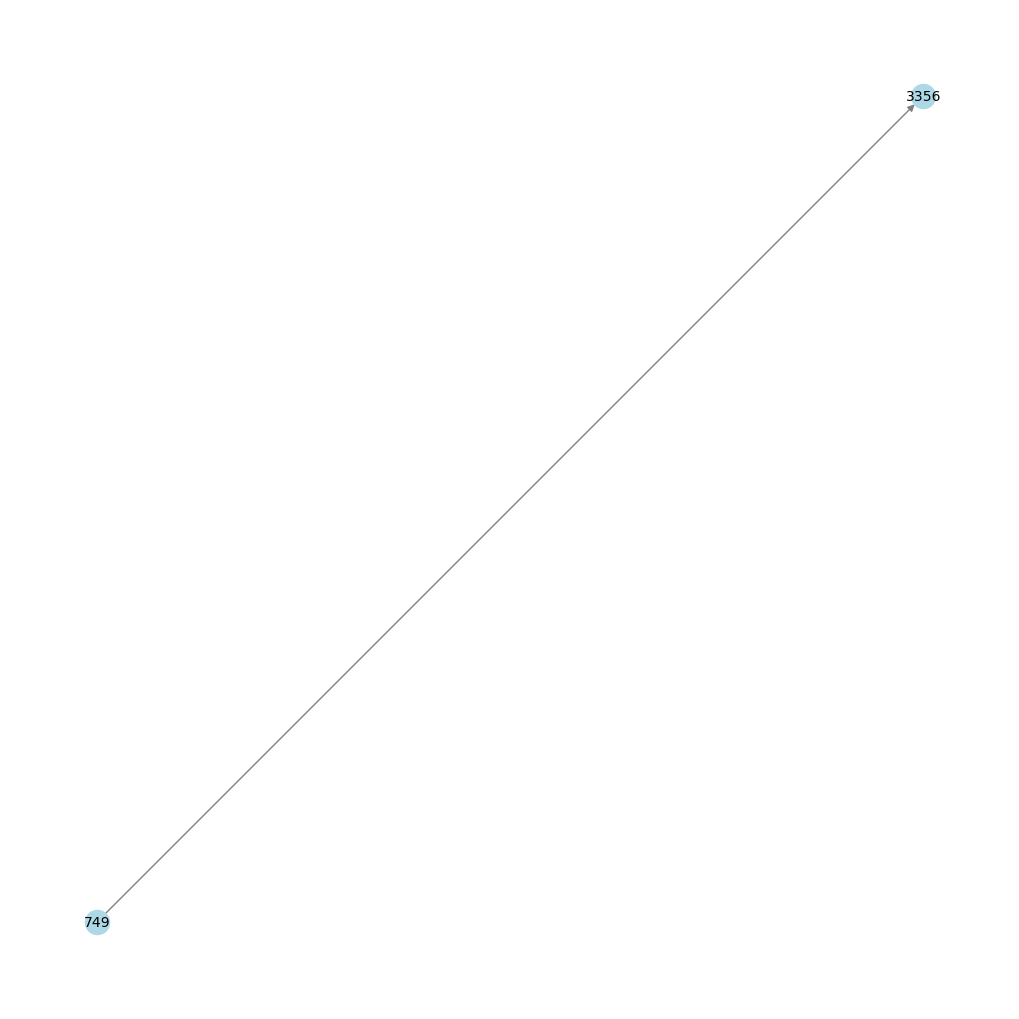

In [7]:
# test use of bgpSubgraph

test = bgpSubgraph("749")
print(test.number_of_nodes())
print(test.number_of_edges())


pos = nx.spring_layout(test, k=0.8)
plt.figure(figsize=(10, 10))
nx.draw(test, pos, with_labels=True, node_color="lightblue", edge_color="gray", font_size=10, arrows=True)
plt.show()

In [8]:
asnLocations = await fetch_until_done(bgpNetwork.nodes())

Timeout while fetching ASN 140119
Timeout while fetching ASN 269538
Timeout while fetching ASN 397213
Timeout while fetching ASN 205312


CancelledError: 

In [11]:
for key, value in asnLocations.items():
    print(f"{key}: {value}")

NameError: name 'asnLocations' is not defined

In [12]:
for asn1, asn2 in bgpNetwork.edges():
    lat1, lon1 = asnLocations[asn1]
    lat2, lon2 = asnLocations[asn2]

    if lat1 == None or lat2 == None or lon1 == None or lon2 == None:
        continue

    distance = haversine(lat1, lon1,lat2, lon2)

    bgpNetwork[asn1][asn2]['weight'] = distance
    

NameError: name 'asnLocations' is not defined

In [ ]:
def get_tier(asn):
    url = f"https://api.asrank.caida.org/v2/restful/asns/{asn}"
    try:
        response = requests.get(url, timeout=5)
        if response.status_code == 200:
            data = response.json().get('data', {}).get('asn', {})
            degrees = data.get('asnDegree', {})
            provider = degrees.get('provider', 0)
            peer = degrees.get('peer', 0)
            customer = degrees.get('customer', 0)
            total = degrees.get('total', 0)
            rank = data.get("rank", float('inf'))
            clique = data.get("cliqueMember", False)

            # Tier 1
            if clique and provider == 0 and peer > 100 and customer > 100 and total > 200:
                return 1

            # Tier 2: 
            elif provider > 0 and peer > 50 and customer > 10 and total > 50:
                return 2

            # Tier 3
            else:
                return 3
    except Exception as e:
        print(f"Error ASN {asn}: {e}")
    return None


In [ ]:
# label
tier_labels = {}
for asn in df.index[:300]:  # labeling 300 for now
    tier = get_tier(asn)
    if tier:
        tier_labels[asn] = tier

df['tier'] = df.index.map(tier_labels)

 # todo check how many dropped
df = df.dropna(subset=['tier'])
df['tier'] = df['tier'].astype(int)

print(df['tier'].value_counts())


3    123
2     58
Name: tier, dtype: int64


In [ ]:

#sus?
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = df[['out_degree', 'in_degree', 'degree_centrality', 'closeness_centrality']]
y = df['tier']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           2       0.65      0.83      0.73        18
           3       0.91      0.78      0.84        37

    accuracy                           0.80        55
   macro avg       0.78      0.81      0.79        55
weighted avg       0.82      0.80      0.80        55



In [27]:
unique = df.index.unique()
print(f"Unique: {len(unique)}")



Unique: 181
